# 🔐 Malicious URL Detection Using Machine Learning  
### 🛡️ Identifying Phishing, Malware, Defacement, and Benign URLs

---

## 📌 Overview

Malicious URLs are among the most widely used attack vectors in modern cybercrime.  
They enable phishing attacks, malware distribution, website defacement, credential theft, and can cause massive financial and data losses.

This project aims to build an **automated machine learning system** that classifies URLs into:

- **benign** — safe URLs  
- **defacement** — compromised or altered sites  
- **phishing** — fraudulent links designed to steal information  
- **malware** — URLs hosting malicious software  

A reliable classifier can significantly enhance cybersecurity systems such as email filters, network firewalls, and browser protection tools.

---

## 📂 Dataset Summary

We use the **Malicious URLs Dataset** from Kaggle, containing **651,191 URLs** collected from reputable cybersecurity sources including ISCX URL 2016, PhishTank, PhishStorm, and Malware Domain List.

**Columns:**
- `url` → raw website link  
- `type` → class label (benign, defacement, phishing, malware)

**Class distribution:**
- 🟢 Benign — 66%  
- 🟠 Defacement — 15%  
- 🔵 Phishing — 14%  
- 🔴 Malware — 5%  

This dataset is large, diverse, and ideal for building robust ML models.

---

## 🛠️ Feature Engineering Summary

To transform raw URLs into useful machine learning features, we engineer multiple lexical and structural attributes, including:

- Presence of IP address  
- URL length & hostname length  
- Count of special characters (`.`, `-`, `/`, `?`, `%`, `@`, etc.)  
- Number of directories & embedded domains  
- Shortening service detection (bit.ly, tinyurl, etc.)  
- Suspicious keywords (login, update, free, paypal…)  
- Digit and letter counts  
- First directory length  
- Top-level domain (TLD) length  

These features help capture phishing behavior, obfuscation techniques, and malicious patterns.

---

## 🤖 Machine Learning Models Used

To compare learning strategies and pick the strongest classifier, we train several models:

### **Traditional ML**
- Decision Tree  
- Random Forest  
- AdaBoost  
- SGD Classifier  
- Extra Trees Classifier  
- Gaussian Naive Bayes  

### **Gradient Boosting**
- Gradient Boosting Classifier  
- XGBoost  

This diverse set helps evaluate performance across linear, tree-based, ensemble, and boosting models.

---

## 🧪 Evaluation Metrics

Because the dataset is **imbalanced**, we evaluate models using:

- Accuracy  
- Precision  
- Recall  
- F1-score (macro & weighted)  
- Confusion matrix  

These metrics ensure fair comparison across all four classes.

---

## 📘 Notebook Roadmap

This notebook includes:

1. **Dataset Loading & Inspection**   
2. **Feature Engineering**  
3. **Model Training & Evaluation**  
4. **Hyperparameters tuning**  
5. **Final Model Selection**

The best-performing model will later be exported and integrated into a deployable machine-learning pipeline.

---

## 🚀 Next Steps

After notebook experimentation, the project will continue with:

- Exporting training logic into **train.py**  
- Creating inference script **predict.py**  
- Building a REST API using **FastAPI/Flask**  
- Packaging the service using **Docker**  
- *(Optional)* Cloud deployment  

---

### ✔️ This notebook lays the foundation for a complete ML solution that transforms raw URLs into actionable cybersecurity intelligence.


# 📌 Dataset Loading & Inspection

In [1]:
!pip install tld


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 7.1 MB/s eta 0:00:00ta 0:00:01


In [2]:
# ============================================================
# Dataset Loading & Inspection
# ============================================================

import pandas as pd
import os
import re
import numpy as np
from urllib.parse import urlparse
from tld import get_tld
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier

# Show available files inside /kaggle/input/
print("📁 Available Dataset Files:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(" -", os.path.join(dirname, filename))

📁 Available Dataset Files:
 - /kaggle/input/malicious-urls-dataset/malicious_phish.csv


In [3]:
# Load dataset
df = pd.read_csv('/kaggle/input/malicious-urls-dataset/malicious_phish.csv')

print("\n✅ Dataset successfully loaded!")
print(f"📊 Shape: {df.shape}")

# Preview first rows
df.head()


✅ Dataset successfully loaded!
📊 Shape: (651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
# ============================================================
# Basic Dataset Information
# ============================================================

print("📘 Dataset Info:")
df.info()

print("\n🔢 Number of Missing Values:")
print(df.isnull().sum())

📘 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB

🔢 Number of Missing Values:
url     0
type    0
dtype: int64



📊 Class Distribution:
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


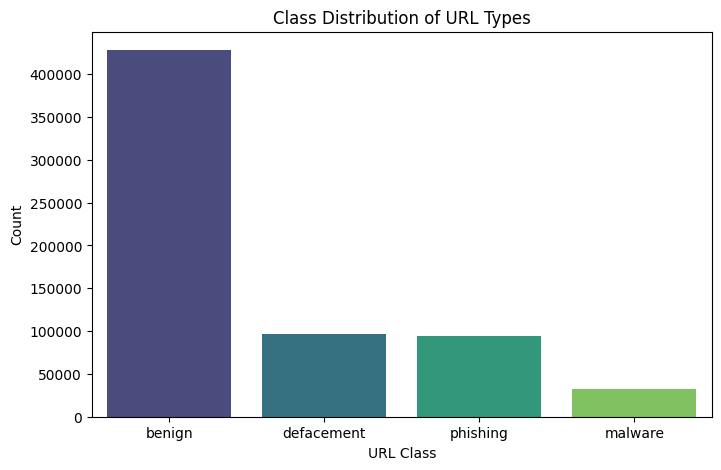

In [5]:
# ============================================================
# Class Distribution
# ============================================================

class_counts = df['type'].value_counts()

print("\n📊 Class Distribution:")
print(class_counts)

# Plot class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution of URL Types")
plt.xlabel("URL Class")
plt.ylabel("Count")
plt.show()



📏 URL Length Statistics:
count    651191.000000
mean         60.156831
std          44.753902
min           1.000000
25%          32.000000
50%          47.000000
75%          77.000000
max        2175.000000
Name: url_length, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


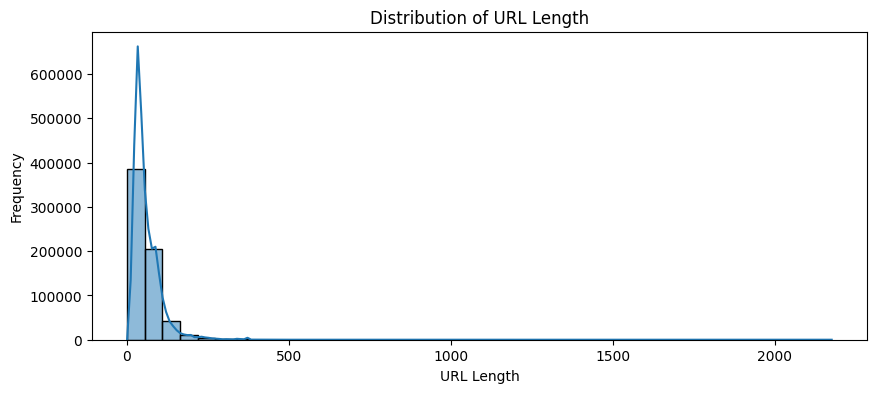

In [6]:
# ============================================================
# Basic URL Length Statistics
# ============================================================

df['url_length'] = df['url'].apply(lambda x: len(str(x)))

print("\n📏 URL Length Statistics:")
print(df['url_length'].describe())

plt.figure(figsize=(10,4))
sns.histplot(df['url_length'], bins=40, kde=True)
plt.title("Distribution of URL Length")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()


In [7]:
# ============================================================
# Preview Samples from Each Class
# ============================================================

for label in df['type'].unique():
    print(f"\n🔹 Example {label} URLs:")
    display(df[df['type'] == label].head(3))



🔹 Example phishing URLs:


,url,type,url_length
0,br-icloud.com.br,phishing,16
21,signin.eby.de.zukruygxctzmmqi.civpro.co.za,phishing,42
28,http://www.marketingbyinternet.com/mo/e56508df...,phishing,71



🔹 Example benign URLs:


,url,type,url_length
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,118



🔹 Example defacement URLs:


,url,type,url_length
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235
8,http://www.pashminaonline.com/pure-pashminas,defacement,44



🔹 Example malware URLs:


,url,type,url_length
38,http://www.824555.com/app/member/SportOption.p...,malware,67
115,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,81
156,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,63


# 🔧 Feature Engineering

In [8]:
# -----------------------------
# IP Address Checker
# -----------------------------
def having_ip_address(url):
    ipv4_pattern = (
        r"(([01]?\d\d?|2[0-4]\d|25[0-5])\.){3}"
        r"([01]?\d\d?|2[0-4]\d|25[0-5])"
    )
    ipv6_pattern = r"([a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}"

    if re.search(ipv4_pattern, url) or re.search(ipv6_pattern, url):
        return 1
    return 0

In [9]:
# -----------------------------
# Abnormal URL
# -----------------------------
def abnormal_url(url):
    hostname = str(urlparse(url).hostname)
    return 0 if hostname and hostname in url else 1

In [10]:
import re

def shortening_service(url):
    """
    Detect if url uses a known URL-shortener domain.
    Returns 1 if yes, 0 otherwise.
    """
    # exhaustive list (case-insensitive)
    pattern = (
        r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
        r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
        r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
        r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|lnkd\.in|'
        r'db\.tt|qr\.ae|adf\.ly|bitly\.com|cur\.lv|tinyurl\.com|ity\.im|'
        r'q\.gs|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
        r'prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
        r'tr\.im|link\.zip\.net'
    )
    return 1 if re.search(pattern, url, re.IGNORECASE) else 0

In [11]:
# -----------------------------
# Count Letters
# -----------------------------
def letter_count(url):
    return sum(c.isalpha() for c in url)

In [12]:
# -----------------------------
# Count Digits
# -----------------------------
def digit_count(url):
    return sum(c.isnumeric() for c in url)

In [13]:
# -----------------------------
# HTTPS Detection
# -----------------------------
def http_secure(url):
    return 1 if urlparse(url).scheme == 'https' else 0

In [14]:
# -----------------------------
# Suspicious Keyword Detection
# -----------------------------
def suspicious_words(url):
    pattern = (
        r"PayPal|login|signin|bank|account|update|free|bonus|service|"
        r"ebayisapi|webscr|lucky|secure|verification|confirm"
    )
    return 1 if re.search(pattern, url, re.IGNORECASE) else 0

In [15]:
# -----------------------------
# Number of Directories
# -----------------------------
def count_directories(url):
    return urlparse(url).path.count('/')

In [16]:
# -----------------------------
# Number of Embedded Domains
# -----------------------------
def count_embedded_domains(url):
    urldir = urlparse(url).path
    return urldir.count('//')

In [17]:
# -----------------------------
# First Directory Length
# -----------------------------
def first_dir_length(url):
    try:
        return len(urlparse(url).path.split('/')[1])
    except:
        return 0

In [18]:
# -----------------------------
# Top-Level Domain Length
# -----------------------------
def tld_length(url):
    try:
        tld = get_tld(url, fail_silently=True)
        return len(tld) if tld else 0
    except:
        return 0

In [19]:
# Basic lexical features
df["url_length"] = df["url"].apply(len)
df["hostname_length"] = df["url"].apply(lambda x: len(urlparse(x).netloc))

df["count_letters"] = df["url"].apply(letter_count)
df["count_digits"] = df["url"].apply(digit_count)

# Special characters
special_chars = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']
for ch in special_chars:
    df[f"count_{ch.replace('//','slashes')}"] = df["url"].apply(lambda x: x.count(ch))

df["count_www"] = df["url"].apply(lambda x: x.count("www"))

# Domain-based features
df["has_ip"] = df["url"].apply(having_ip_address)
df["abnormal_url"] = df["url"].apply(abnormal_url)
df["short_url"] = df["url"].apply(shortening_service)
df["https"] = df["url"].apply(http_secure)

df["count_dir"] = df["url"].apply(count_directories)
df["count_embed_domain"] = df["url"].apply(count_embedded_domains)
df["fd_length"] = df["url"].apply(first_dir_length)

# TLD
df["tld_length"] = df["url"].apply(tld_length)

# Suspicious keywords
df["suspicious"] = df["url"].apply(suspicious_words)


In [20]:
df.head()

,url,type,url_length,hostname_length,count_letters,count_digits,count_@,count_?,count_-,count_=,...,count_www,has_ip,abnormal_url,short_url,https,count_dir,count_embed_domain,fd_length,tld_length,suspicious
0,br-icloud.com.br,phishing,16,0,13,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,29,1,0,0,0,0,...,0,0,1,0,0,2,0,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,25,1,0,0,0,0,...,0,0,1,0,0,3,0,7,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,21,63,7,0,1,1,4,...,1,0,0,0,0,1,0,9,2,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,23,199,22,0,1,1,3,...,0,0,0,0,0,1,0,9,3,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   url                 651191 non-null  object
 1   type                651191 non-null  object
 2   url_length          651191 non-null  int64 
 3   hostname_length     651191 non-null  int64 
 4   count_letters       651191 non-null  int64 
 5   count_digits        651191 non-null  int64 
 6   count_@             651191 non-null  int64 
 7   count_?             651191 non-null  int64 
 8   count_-             651191 non-null  int64 
 9   count_=             651191 non-null  int64 
 10  count_.             651191 non-null  int64 
 11  count_#             651191 non-null  int64 
 12  count_%             651191 non-null  int64 
 13  count_+             651191 non-null  int64 
 14  count_$             651191 non-null  int64 
 15  count_!             651191 non-null  int64 
 16  co

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["label"] = le.fit_transform(df["type"])

In [23]:
exclude_cols = ["url", "type"]
feature_cols = [col for col in df.columns if col not in exclude_cols + ["label"]]

X = df[feature_cols]
y = df["label"]

X.shape, y.shape

((651191, 27), (651191,))

In [24]:
df.head()

,url,type,url_length,hostname_length,count_letters,count_digits,count_@,count_?,count_-,count_=,...,has_ip,abnormal_url,short_url,https,count_dir,count_embed_domain,fd_length,tld_length,suspicious,label
0,br-icloud.com.br,phishing,16,0,13,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,29,1,0,0,0,0,...,0,1,0,0,2,0,5,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,25,1,0,0,0,0,...,0,1,0,0,3,0,7,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,21,63,7,0,1,1,4,...,0,0,0,0,1,0,9,2,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,23,199,22,0,1,1,3,...,0,0,0,0,1,0,9,3,0,1


# 🚀 Model Training

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
  
X_train.shape, X_test.shape


((520952, 27), (130239, 27))

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, average='macro'),
        "Recall": recall_score(y_test, preds, average='macro'),
        "F1 Score": f1_score(y_test, preds, average='macro')
    }


In [27]:
print("Evaluating Decision Tree...")

dt_result = evaluate_model(
    "Decision Tree",
    DecisionTreeClassifier(
        max_depth=15,
        min_samples_split=10
    )
)

dt_result


Evaluating Decision Tree...


{'Model': 'Decision Tree',
 'Accuracy': 0.9586836508265574,
 'Precision': 0.9495284882900576,
 'Recall': 0.9226016978027709,
 'F1 Score': 0.935065992999871}

In [28]:
print("Evaluating Random Forest...")

rf_result = evaluate_model(
    "Random Forest",
    RandomForestClassifier(
        n_estimators=120,
        max_depth=18,
        n_jobs=-1
    )
)

rf_result


Evaluating Random Forest...


{'Model': 'Random Forest',
 'Accuracy': 0.9638357174118352,
 'Precision': 0.9640429414057228,
 'Recall': 0.9310767458403011,
 'F1 Score': 0.9462673258420042}

In [29]:
print("Evaluating Extra Trees...")

et_result = evaluate_model(
    "Extra Trees",
    ExtraTreesClassifier(
        n_estimators=150,
        max_depth=20,
        n_jobs=-1
    )
)

et_result


Evaluating Extra Trees...


{'Model': 'Extra Trees',
 'Accuracy': 0.9349042913413033,
 'Precision': 0.9321150079477615,
 'Recall': 0.8620097184589581,
 'F1 Score': 0.889522152785843}

In [30]:
print("Evaluating AdaBoost...")

ada_result = evaluate_model(
    "AdaBoost",
    AdaBoostClassifier(
        n_estimators=80,
        learning_rate=0.8
    )
)

ada_result


Evaluating AdaBoost...


{'Model': 'AdaBoost',
 'Accuracy': 0.592710324864288,
 'Precision': 0.738910309613056,
 'Recall': 0.702915624099794,
 'F1 Score': 0.6457606620353683}

In [31]:
print("Evaluating Gaussian NB...")

nb_result = evaluate_model(
    "Gaussian NB",
    GaussianNB()
)

nb_result


Evaluating Gaussian NB...


{'Model': 'Gaussian NB',
 'Accuracy': 0.8230560738334908,
 'Precision': 0.7344930183829883,
 'Recall': 0.7389443520798025,
 'F1 Score': 0.7126781592530067}

In [32]:
print("Evaluating SGD Classifier...")

sgd_result = evaluate_model(
    "SGD Classifier",
    SGDClassifier(
        max_iter=1200,
        loss='log_loss',   # fixed warning
        penalty='l2'
    )
)

sgd_result


Evaluating SGD Classifier...


{'Model': 'SGD Classifier',
 'Accuracy': 0.8608097420895431,
 'Precision': 0.8284547896313238,
 'Recall': 0.7429505013552999,
 'F1 Score': 0.7581088564066063}

In [33]:
print("Evaluating Gradient Boosting...")

gb_result = evaluate_model(
    "Gradient Boosting",
    GradientBoostingClassifier(
        n_estimators=120,
        learning_rate=0.1,
        max_depth=3
    )
)

gb_result


Evaluating Gradient Boosting...


{'Model': 'Gradient Boosting',
 'Accuracy': 0.944908975038199,
 'Precision': 0.9287400071510472,
 'Recall': 0.8866965900997986,
 'F1 Score': 0.9055260974206342}

In [34]:
print("Evaluating XGBoost...")

xgb_result = evaluate_model(
    "XGBoost",
    XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        tree_method='hist',  # super fast
        n_jobs=-1
    )
)

xgb_result


Evaluating XGBoost...


{'Model': 'XGBoost',
 'Accuracy': 0.9605187386266787,
 'Precision': 0.9556815569971517,
 'Recall': 0.9255453778244624,
 'F1 Score': 0.9395973019686056}

In [35]:
results = [
    dt_result,
    rf_result,
    et_result,
    ada_result,
    nb_result,
    sgd_result,
    gb_result,
    xgb_result,
]

results_df = pd.DataFrame(results)
results_df=results_df.sort_values("Accuracy", ascending=False)
results_df


,Model,Accuracy,Precision,Recall,F1 Score
1,Random Forest,0.963836,0.964043,0.931077,0.946267
7,XGBoost,0.960519,0.955682,0.925545,0.939597
0,Decision Tree,0.958684,0.949528,0.922602,0.935066
6,Gradient Boosting,0.944909,0.928740,0.886697,0.905526
2,Extra Trees,0.934904,0.932115,0.862010,0.889522
5,SGD Classifier,0.860810,0.828455,0.742951,0.758109
4,Gaussian NB,0.823056,0.734493,0.738944,0.712678
3,AdaBoost,0.592710,0.738910,0.702916,0.645761


# 🟢 Hyperparameters Tuning

In [36]:
# Take only 80,000 samples for tuning (adjustable)
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train,
    train_size=80000,
    stratify=y_train,
    random_state=42
)

print("Tuning dataset shape:", X_tune.shape)

Tuning dataset shape: (80000, 27)


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
    "n_estimators": [80, 120, 160],
    "max_depth": [12, 16, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_model = RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring="f1_macro",
    cv=2,              
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_tune, y_tune)

print("Best RF Params:", rf_grid.best_params_)
print("Best RF F1-macro:", rf_grid.best_score_)


Fitting 2 folds for each of 36 candidates, totalling 72 fits
Best RF Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160}
Best RF F1-macro: 0.9325628799474868


In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    "n_estimators": [150, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [5, 6],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
}

xgb_model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring="f1_macro",
    cv=2,              
    verbose=1,
    n_jobs=-1
)

xgb_grid.fit(X_tune, y_tune)

print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB F1-macro:", xgb_grid.best_score_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best XGB Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best XGB F1-macro: 0.9297285465612526


# ✅ Final Model Selection

In [39]:
from sklearn.metrics import f1_score

rf_best = rf_grid.best_estimator_
rf_best.fit(X_train, y_train)

rf_pred = rf_best.predict(X_test)
print("Random-Forest best-params score (CV): {:.4f}".format(rf_grid.best_score_))
print("Random-Forest F1-macro on TEST:       {:.4f}".format(f1_score(y_test, rf_pred, average='macro')))

xgb_best = xgb_grid.best_estimator_
xgb_best.fit(X_train, y_train)

xgb_pred = xgb_best.predict(X_test)
print("XGBoost best-params score (CV): {:.4f}".format(xgb_grid.best_score_))
print("XGBoost F1-macro on TEST:       {:.4f}".format(f1_score(y_test, xgb_pred, average='macro')))

Random-Forest best-params score (CV): 0.9326
Random-Forest F1-macro on TEST:       0.9506
XGBoost best-params score (CV): 0.9297
XGBoost F1-macro on TEST:       0.9396


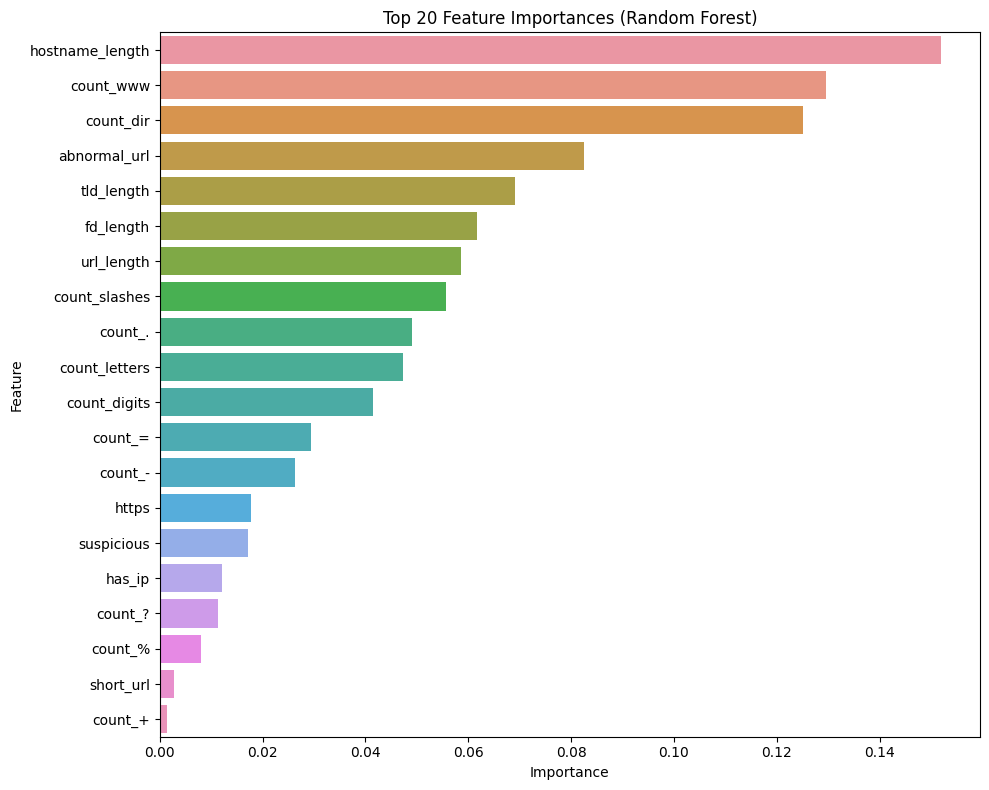

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
importances = rf_best.feature_importances_
feat_names = X_train.columns

# Sort by importance
indices = importances.argsort()[::-1]
top_n = 20  

plt.figure(figsize=(10, 8))
sns.barplot(
    x=importances[indices][:top_n],
    y=feat_names[indices][:top_n]
)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


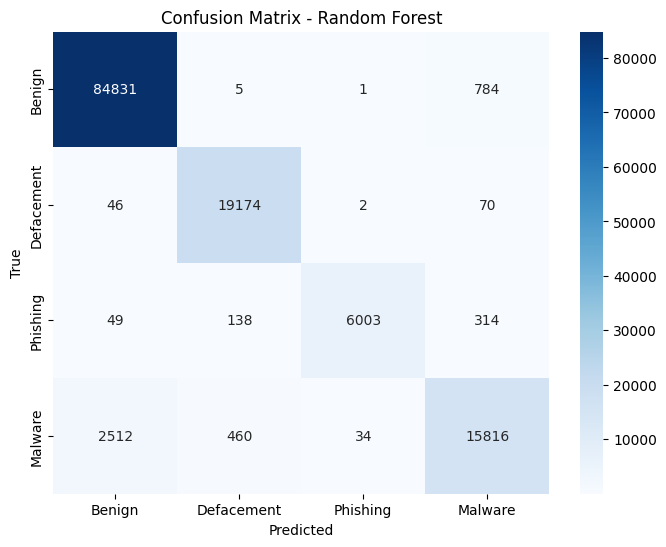

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf_pred)
labels = ["Benign", "Defacement", "Phishing", "Malware"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [42]:
from sklearn.metrics import classification_report

print("Classification Report (Random Forest):\n")
print(classification_report(y_test, rf_pred))


Classification Report (Random Forest):

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85621
           1       0.97      0.99      0.98     19292
           2       0.99      0.92      0.96      6504
           3       0.93      0.84      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.97      0.94      0.95    130239
weighted avg       0.97      0.97      0.97    130239



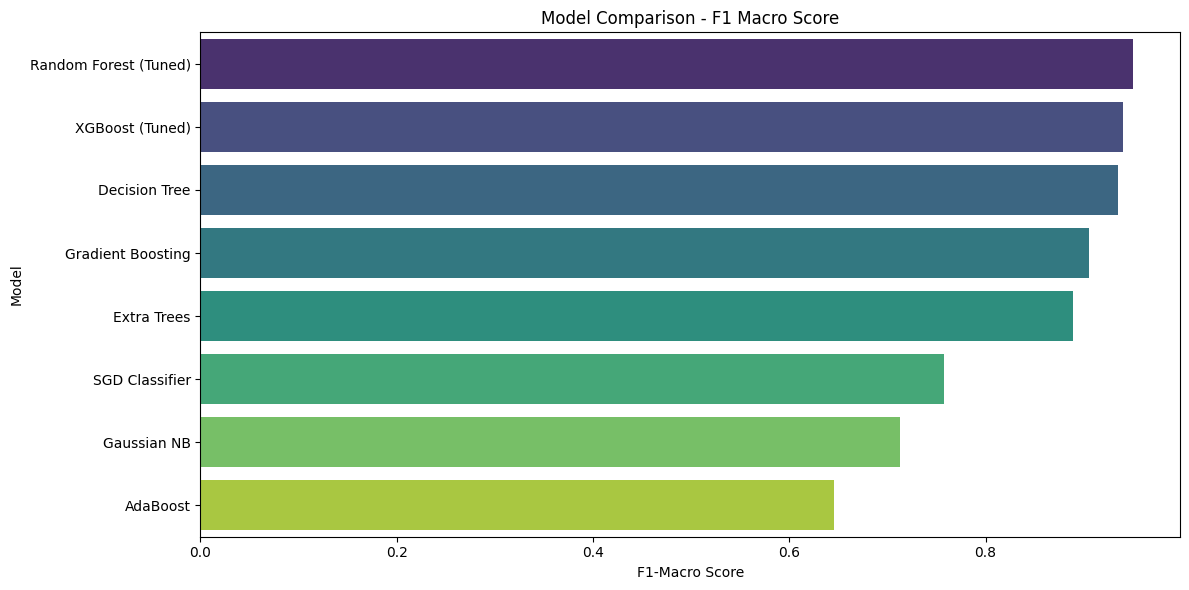

,Model,F1-Macro
1,Random Forest (Tuned),0.950614
2,XGBoost (Tuned),0.939630
0,Decision Tree,0.935066
7,Gradient Boosting,0.905526
3,Extra Trees,0.889522
6,SGD Classifier,0.758109
5,Gaussian NB,0.712678
4,AdaBoost,0.645761


In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame({
    "Model": [
        "Decision Tree", "Random Forest (Tuned)", "XGBoost (Tuned)",
        "Extra Trees", "AdaBoost", "Gaussian NB",
        "SGD Classifier", "Gradient Boosting"
    ],
    "F1-Macro": [
        dt_result["F1 Score"],
        rf_best_f1 := f1_score(y_test, rf_pred, average='macro'),
        xgb_best_f1 := f1_score(y_test, xgb_pred, average='macro'),
        et_result["F1 Score"],
        ada_result["F1 Score"],
        nb_result["F1 Score"],
        sgd_result["F1 Score"],
        gb_result["F1 Score"],
    ]
})

comparison_df = comparison_df.sort_values("F1-Macro", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x="F1-Macro", y="Model", palette="viridis")
plt.title("Model Comparison - F1 Macro Score")
plt.xlabel("F1-Macro Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

comparison_df


In [44]:
import pickle

with open("final_random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_best, f)

print("Random Forest model saved as 'final_random_forest_model.pkl'")


Random Forest model saved as 'final_random_forest_model.pkl'


In [45]:
# Load the saved Random Forest model
with open("final_random_forest_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("Model loaded successfully!")


Model loaded successfully!


In [46]:
special_chars = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']

def extract_url_features(url):
    data = {}

    # Basic lexical
    data["url_length"] = len(url)
    data["hostname_length"] = len(urlparse(url).netloc)
    data["count_letters"] = letter_count(url)
    data["count_digits"] = digit_count(url)

    # Special characters
    for ch in special_chars:
        col_name = f"count_{ch.replace('//','slashes')}"
        data[col_name] = url.count(ch)

    data["count_www"] = url.count("www")

    # Domain-based
    data["has_ip"] = having_ip_address(url)
    data["abnormal_url"] = abnormal_url(url)
    data["short_url"] = shortening_service(url)
    data["https"] = http_secure(url)
    data["count_dir"] = count_directories(url)
    data["count_embed_domain"] = count_embedded_domains(url)
    data["fd_length"] = first_dir_length(url)

    # TLD
    data["tld_length"] = tld_length(url)

    # Suspicious keywords
    data["suspicious"] = suspicious_words(url)

    return pd.DataFrame([data])

In [47]:
test_urls = [
    "br-icloud.com.br",
    "http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15"

]

label_map = {0: "Benign", 1: "Defacement", 2: "Malware", 3: "Phishing" }

for url in test_urls:
    features = extract_url_features(url)
    pred = loaded_model.predict(features)[0]
    print(f"\n🔍 URL: {url}")
    print(f"➡️ Prediction: {label_map[pred]}")



🔍 URL: br-icloud.com.br
➡️ Prediction: Phishing

🔍 URL: http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15
➡️ Prediction: Defacement
